In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from utils.data_loader import load_stock_data, split_data
from utils.statistical_tests import find_cointegrated_pairs
from models.cointegration import CointegrationModel
from strategies.cointegrationtrading import CointegrationTrader
from utils.visualization import plot_cointegration_trade

In [4]:
os.makedirs("results", exist_ok=True)

data_path = os.path.join("data", "jse_stocks.csv")
print(f"Chargement des données à partir de {data_path}...")

prices = pd.read_csv(data_path, index_col=0, parse_dates=True)
print(prices.shape)

try:
    sector_path = os.path.join("data", "jse_sectors.csv")
    sectors_df = pd.read_csv(sector_path)
    sectors = dict(zip(sectors_df["Ticker"], sectors_df["Sector"]))
    print(f"Informations sectorielles chargées pour {len(sectors)} actions")
except:
    sectors = {}
    print("Informations sectorielles non disponibles")

Chargement des données à partir de data\jse_stocks.csv...
(6486, 51)
Informations sectorielles chargées pour 51 actions


In [5]:
train_data, test_data = split_data(prices, train_ratio=0.7)
print("\nRecherche de paires co-intégrées (cela peut prendre quelques minutes)...")
cointegrated_pairs = find_cointegrated_pairs(train_data, significance_level=0.01)

print(f"Trouvé {len(cointegrated_pairs)} paires co-intégrées sur toute la période disponible")


Recherche de paires co-intégrées (cela peut prendre quelques minutes)...
Trouvé 24 paires co-intégrées sur toute la période disponible



Analyse de la paire 1: IMP.JO - AEG.JO (p-value: 0.000004)
  Secteurs: IMP.JO (Resources), AEG.JO (Construction)
  Même secteur: Non

Analyse de la paire 2: APN.JO - RDF.JO (p-value: 0.000010)
  Secteurs: APN.JO (Healthcare), RDF.JO (Property)
  Même secteur: Non

Analyse de la paire 3: WHL.JO - RDF.JO (p-value: 0.000017)
  Secteurs: WHL.JO (Industrials), RDF.JO (Property)
  Même secteur: Non

Analyse de la paire 4: AVI.JO - RDF.JO (p-value: 0.000027)
  Secteurs: AVI.JO (Industrials), RDF.JO (Property)
  Même secteur: Non

Analyse de la paire 5: FSR.JO - SLM.JO (p-value: 0.000058)
  Secteurs: FSR.JO (Financials), SLM.JO (Financials)
  Même secteur: Oui


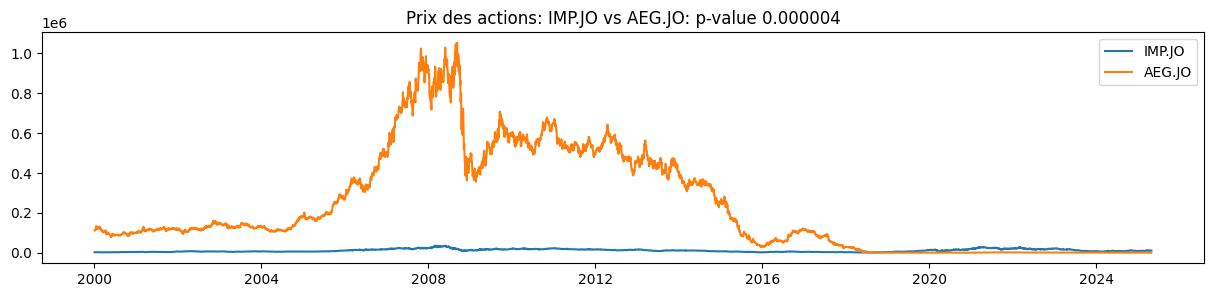

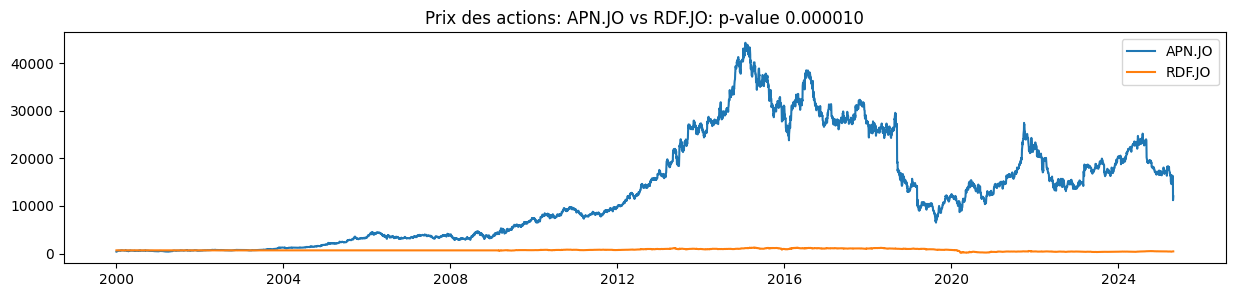

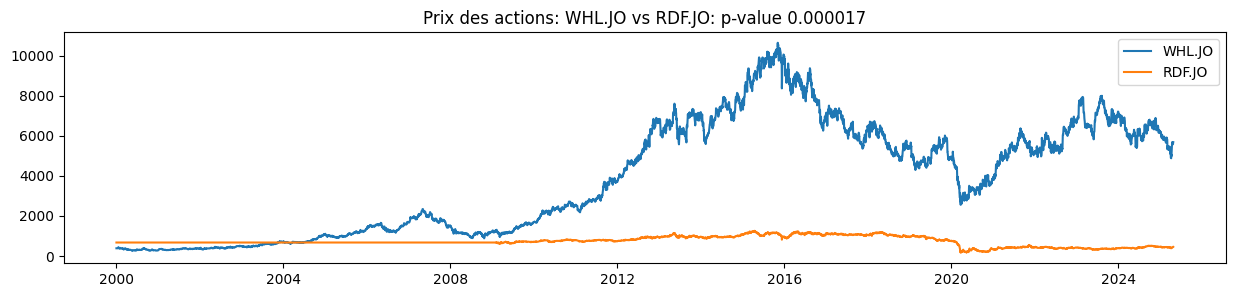

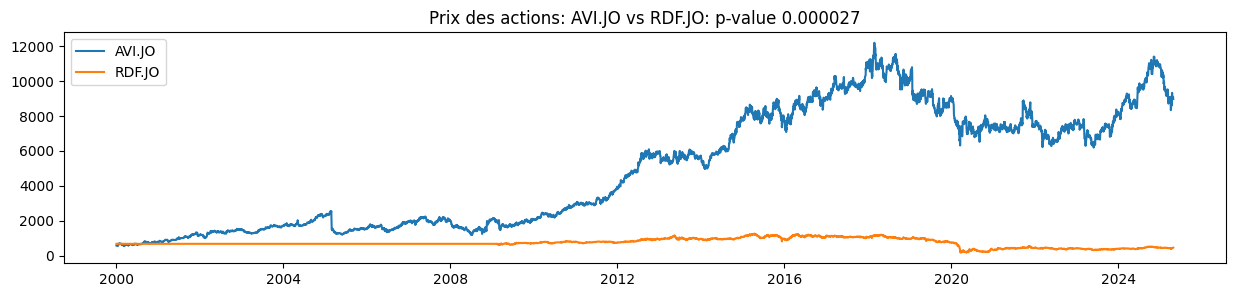

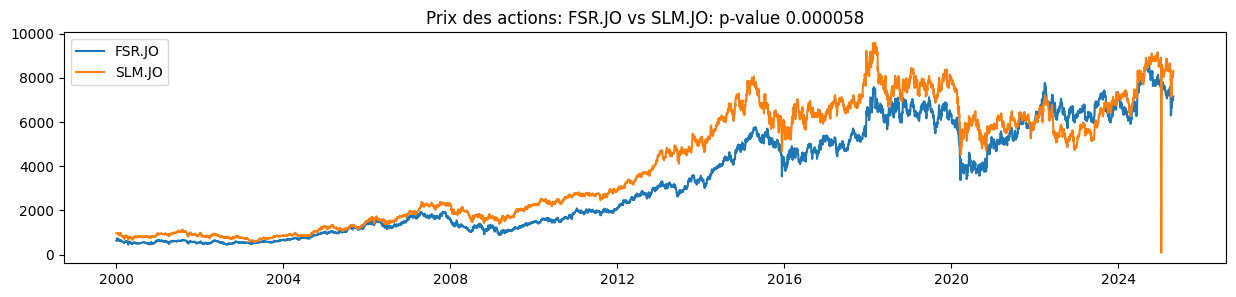

In [6]:
cointegrated_pairs.sort(key=lambda x: x[2])
top_pairs = cointegrated_pairs[:5]
results = []

for i, (ticker1, ticker2, p_value) in enumerate(top_pairs):
    print(
        f"\nAnalyse de la paire {i+1}: {ticker1} - {ticker2} (p-value: {p_value:.6f})"
    )
    sector1 = sectors.get(ticker1, "Inconnu")
    sector2 = sectors.get(ticker2, "Inconnu")
    same_sector = sector1 == sector2

    print(f"  Secteurs: {ticker1} ({sector1}), {ticker2} ({sector2})")
    print(f"  Même secteur: {'Oui' if same_sector else 'Non'}")

    # Plot des prix, spread et résidus
    plt.figure(figsize=(15, 3))
    plt.plot(prices[ticker1], label=ticker1)
    plt.plot(prices[ticker2], label=ticker2)
    plt.title(f"Prix des actions: {ticker1} vs {ticker2}: p-value {p_value:.6f}")
    plt.legend()


Analyse de la paire 1: IMP.JO - AEG.JO (p-value: 0.000004)
  Secteurs: IMP.JO (Resources), AEG.JO (Construction)
  Même secteur: Non
  Performance: Rendement total: 1702.5151, Sharpe: 0.4130, Trades: 68


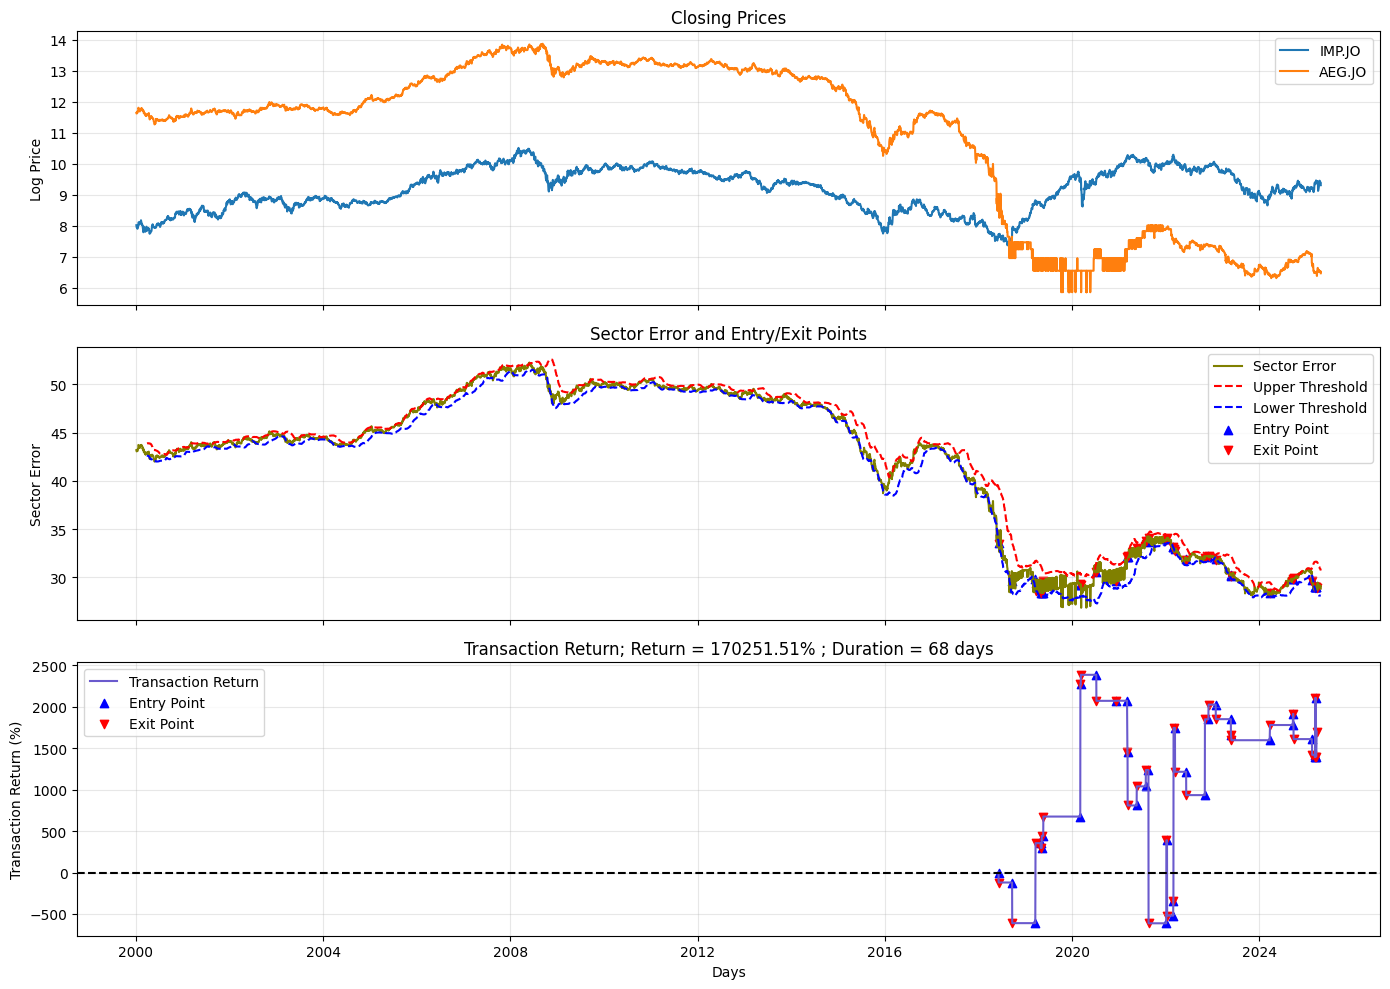


Analyse de la paire 2: APN.JO - RDF.JO (p-value: 0.000010)
  Secteurs: APN.JO (Healthcare), RDF.JO (Property)
  Même secteur: Non
  Performance: Rendement total: 2668.6052, Sharpe: 0.8414, Trades: 86


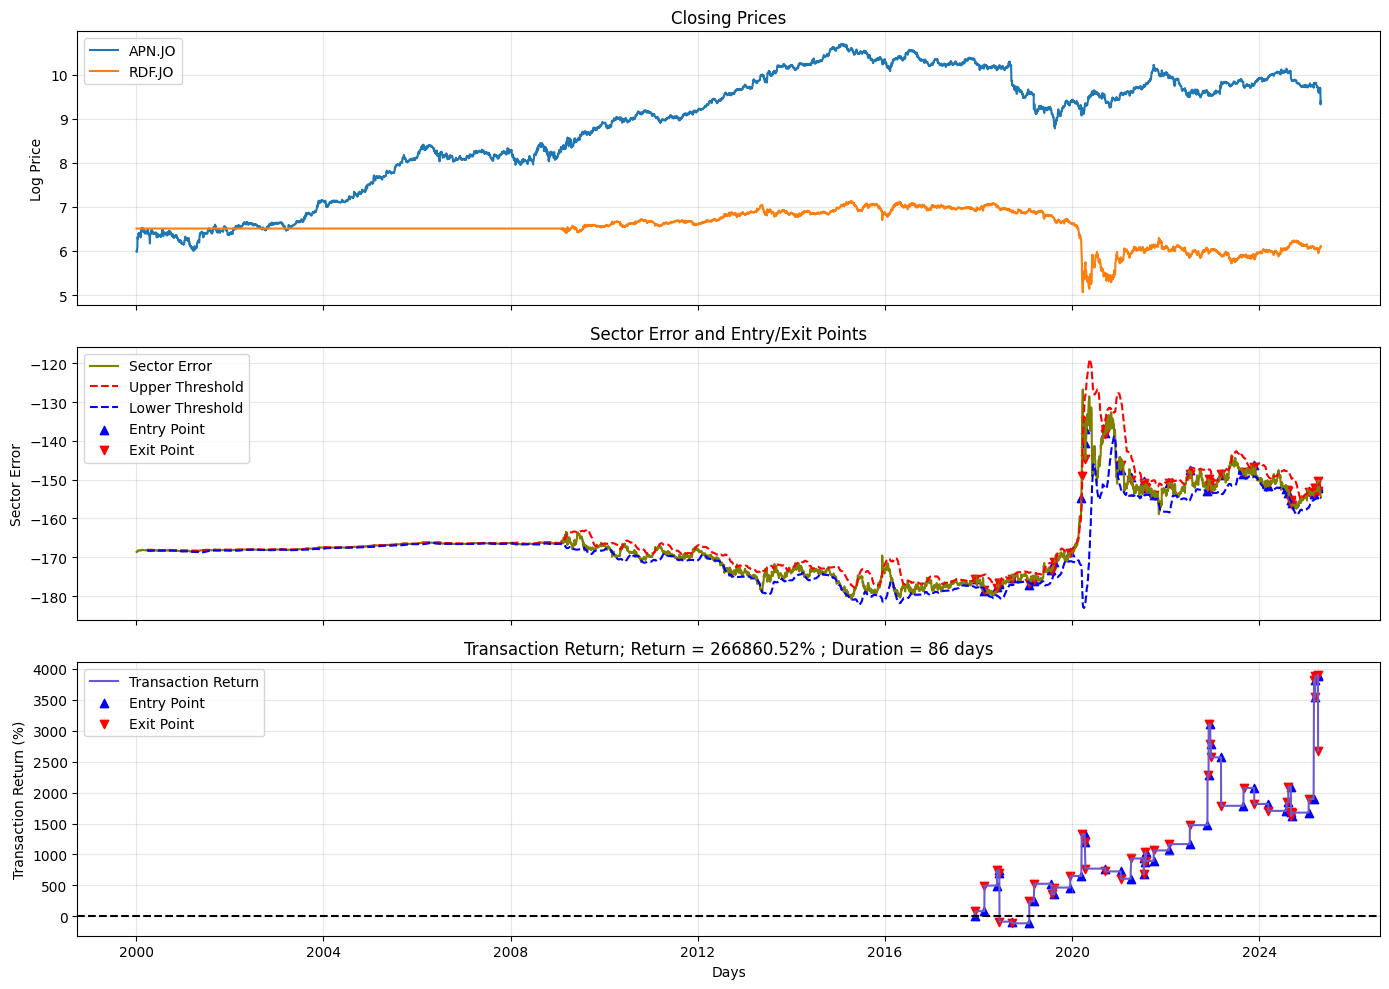


Analyse de la paire 3: WHL.JO - RDF.JO (p-value: 0.000017)
  Secteurs: WHL.JO (Industrials), RDF.JO (Property)
  Même secteur: Non
  Performance: Rendement total: -703.1828, Sharpe: -0.8817, Trades: 52


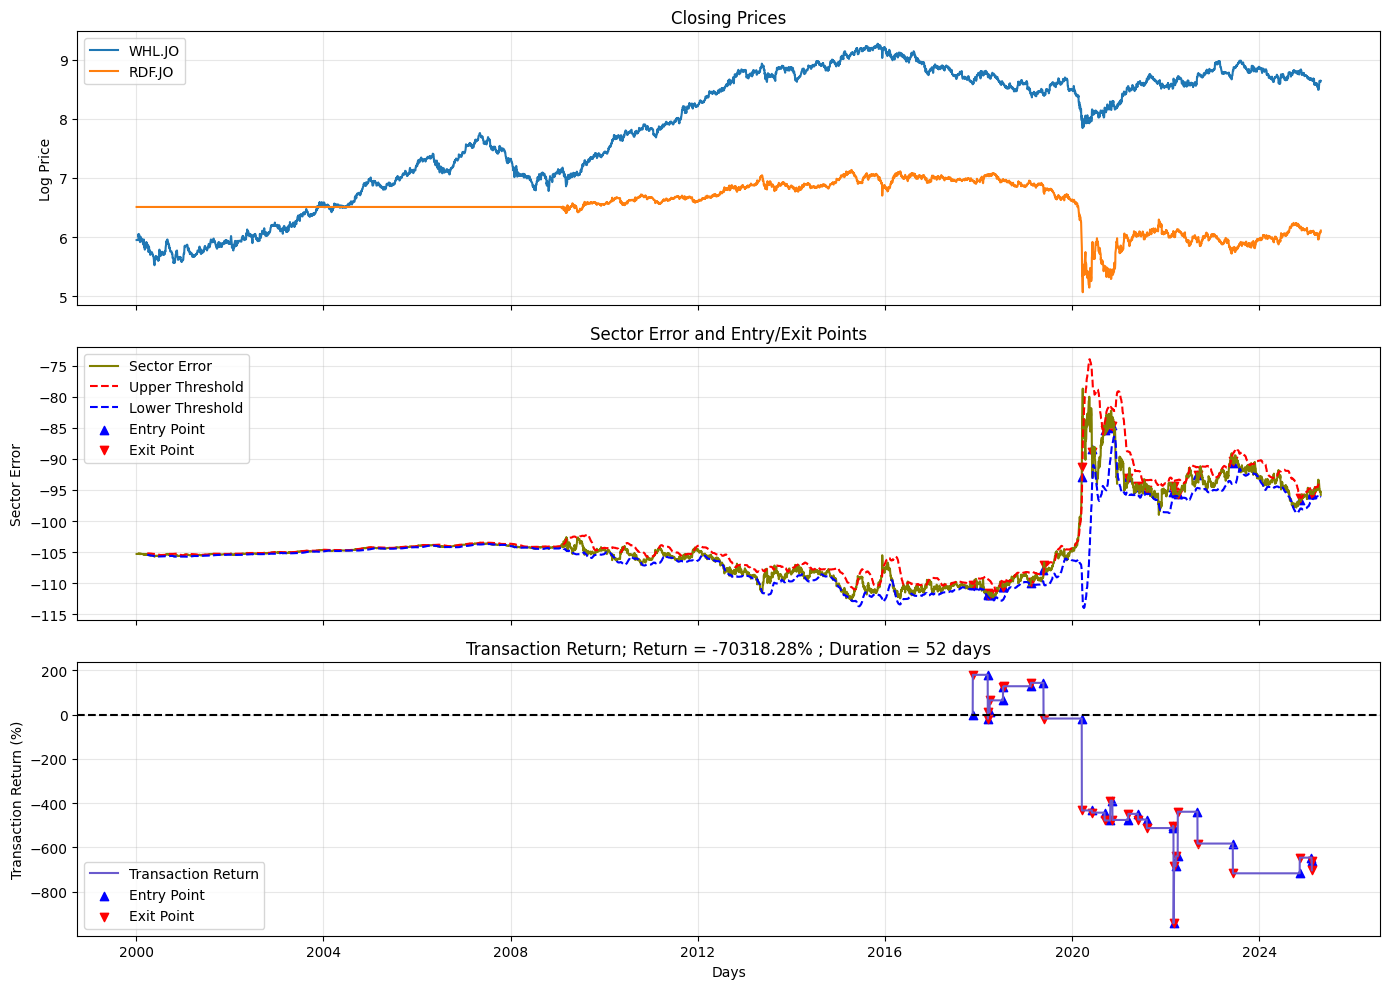


Analyse de la paire 4: AVI.JO - RDF.JO (p-value: 0.000027)
  Secteurs: AVI.JO (Industrials), RDF.JO (Property)
  Même secteur: Non
  Performance: Rendement total: -585.9413, Sharpe: -0.5277, Trades: 105


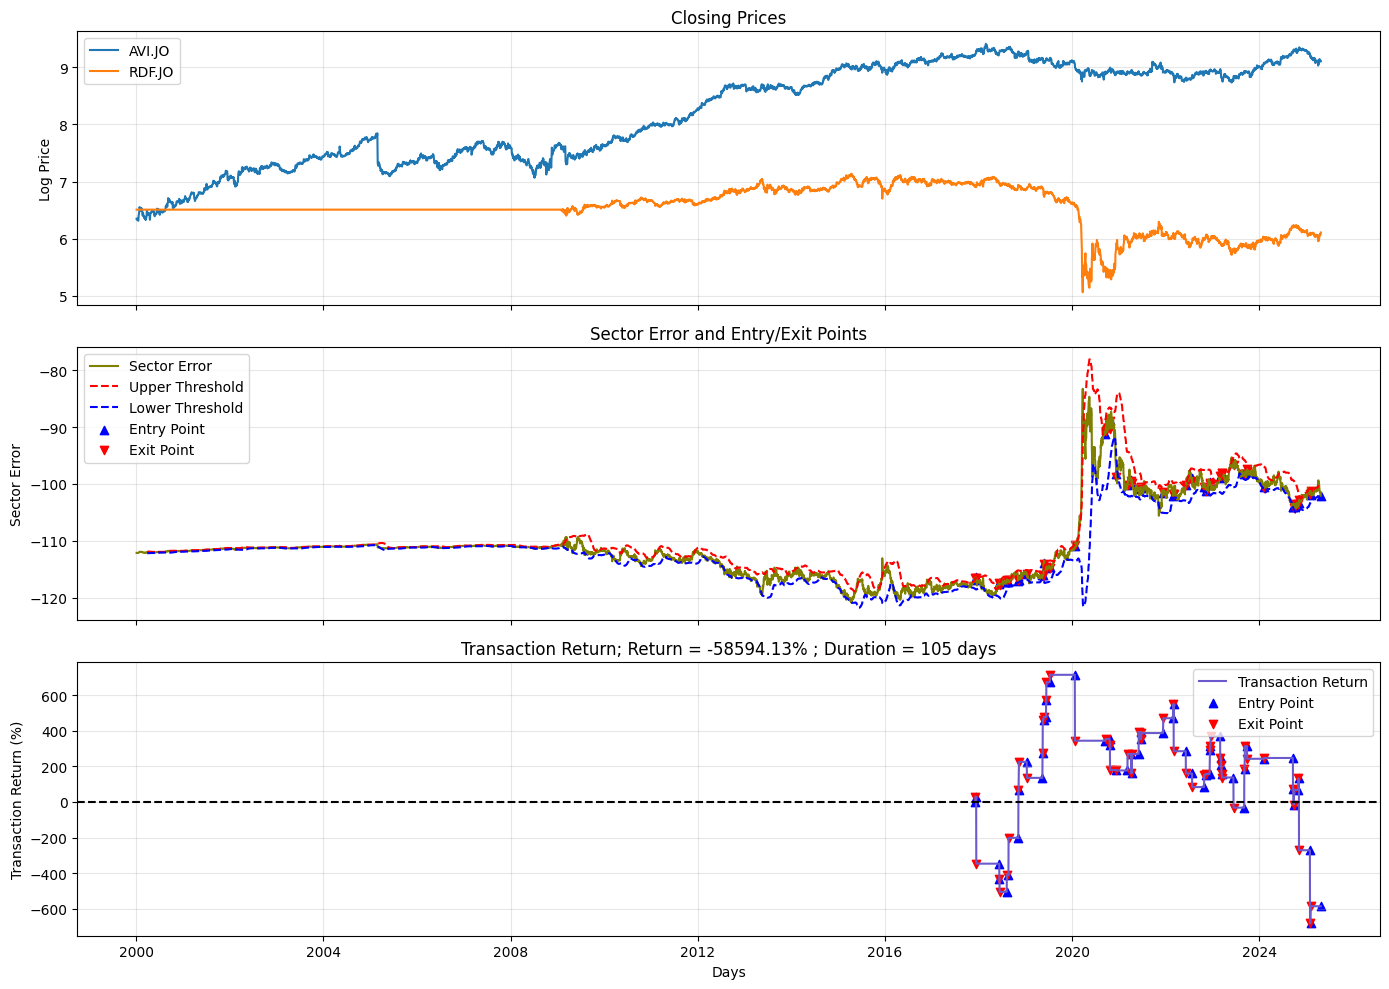


Analyse de la paire 5: FSR.JO - SLM.JO (p-value: 0.000058)
  Secteurs: FSR.JO (Financials), SLM.JO (Financials)
  Même secteur: Oui
  Performance: Rendement total: 6904.1346, Sharpe: 1.1659, Trades: 74


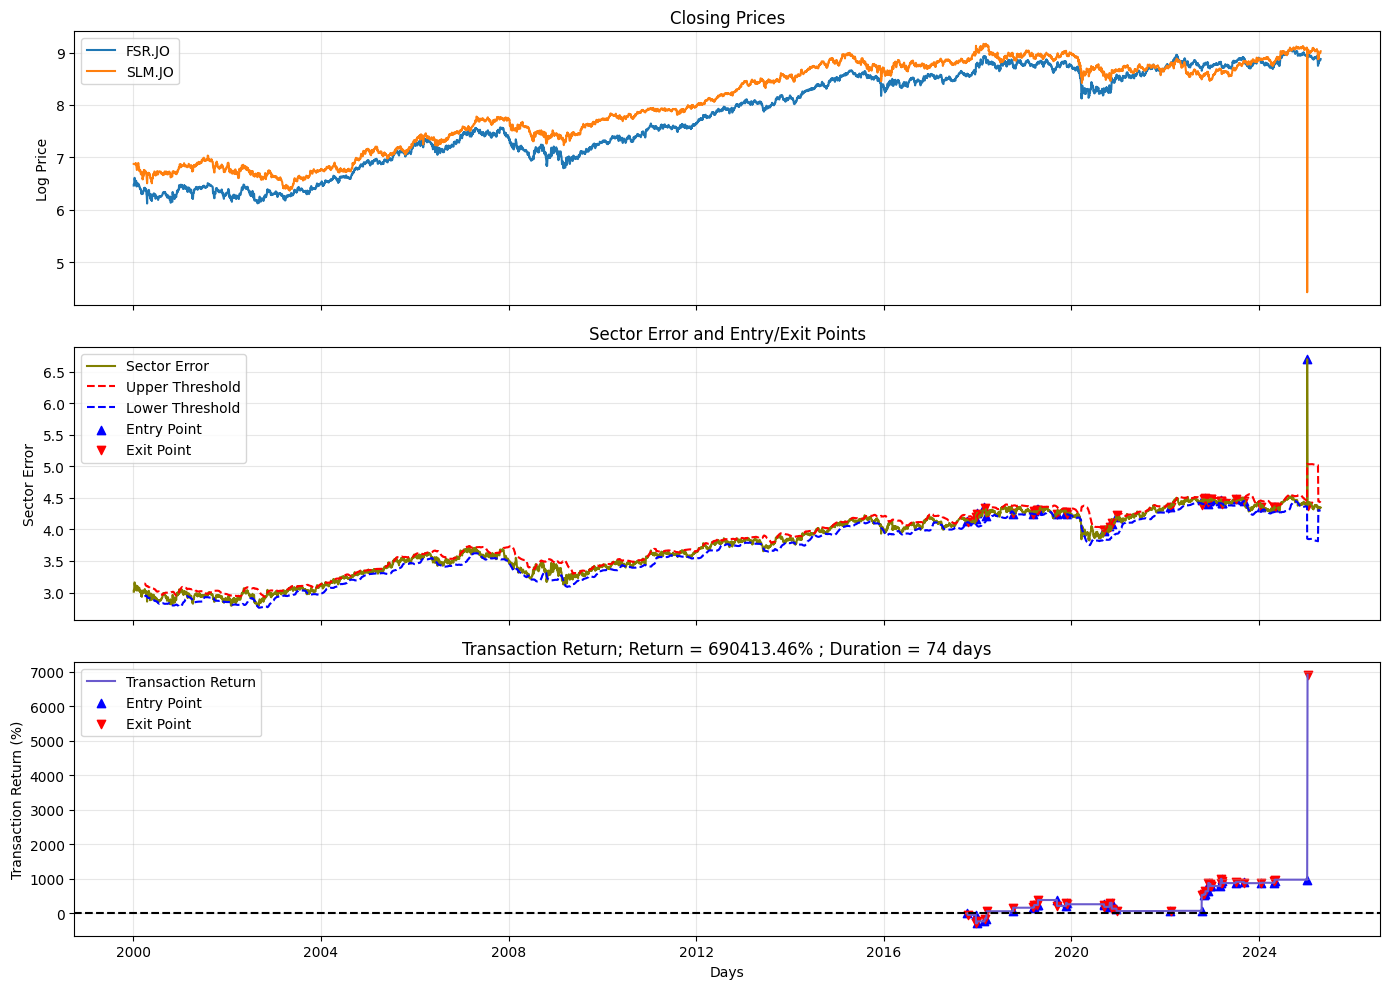

In [7]:
for i, (ticker1, ticker2, p_value) in enumerate(top_pairs):
    print(f"\nAnalyse de la paire {i+1}: {ticker1} - {ticker2} (p-value: {p_value:.6f})")

    sector1 = sectors.get(ticker1, "Inconnu")
    sector2 = sectors.get(ticker2, "Inconnu")
    same_sector = sector1 == sector2

    print(f"  Secteurs: {ticker1} ({sector1}), {ticker2} ({sector2})")
    print(f"  Même secteur: {'Oui' if same_sector else 'Non'}")

    model = CointegrationModel(significance_level=0.05)

    trader = CointegrationTrader(
    model,
    entry_threshold=2.0,
    stop_loss=0.05,
    profit_target=0.05,
    rolling_window=60
)


    trades = trader.run_backtest(
        test_data[ticker1], test_data[ticker2]
    )

    if trades.empty:
        print("  ⚠️  Aucun trade réalisé.")
        continue

    pnl_total = trades["pnl"].sum()
    pnl_moyen = trades["pnl"].mean()
    nb_trades = len(trades)
    max_drawdown = trades["pnl"].min()

    pnl_values = trades["pnl"].values
    sharpe = (
        np.mean(pnl_values) / np.std(pnl_values) * np.sqrt(len(pnl_values))
        if len(pnl_values) >= 2 and np.std(pnl_values) > 0
        else 0
    )

    print(
        f"  Performance: Rendement total: {pnl_total:.4f}, Sharpe: {sharpe:.4f}, Trades: {nb_trades}"
    )

    results.append(
        {
            "Ticker1": ticker1,
            "Ticker2": ticker2,
            "Sector1": sector1,
            "Sector2": sector2,
            "Same_Sector": same_sector,
            "p_value": p_value,
            "Beta": model.beta,
            "Intercept": model.intercept,
            "Total_Return": pnl_total,
            "Mean_PnL": pnl_moyen,
            "Max_Drawdown": max_drawdown,
            "Sharpe": sharpe,
            "Nb_Trades": nb_trades,
        }
    )
    
    plot_cointegration_trade(
        prices=prices,
        ticker1=ticker1,
        ticker2=ticker2,
        trades=trades,
        beta=model.beta,
        entry_threshold=2.0
    )

In [8]:
for i, (ticker1, ticker2, p_value) in enumerate(cointegrated_pairs):
    trades = trader.run_backtest(
            test_data[ticker1],
            test_data[ticker2],
        )
    print(
        f"\nAnalyse de la paire {i+1}: {ticker1} - {ticker2} (p-value: {p_value:.6f})")

    if trades.empty:
        print("  ⚠️  Aucun trade réalisé.")
        continue

    pnl_total = trades["pnl"].sum()
    pnl_moyen = trades["pnl"].mean()
    nb_trades = len(trades)
    max_drawdown = trades["pnl"].min()

    pnl_values = trades["pnl"].values

    if len(pnl_values) >= 2 and np.std(pnl_values) > 0:
        sharpe = np.mean(pnl_values) / np.std(pnl_values) * np.sqrt(len(pnl_values))
    else:
        sharpe = 0

    print(
        f"  Performance: Rendement total: {pnl_total:.4f}, Sharpe: {sharpe:.4f}, Trades: {nb_trades}"
    )

    results.append(
        {
            "Ticker1": ticker1,
            "Ticker2": ticker2,
            "Sector1": sector1,
            "Sector2": sector2,
            "Same_Sector": same_sector,
            "p_value": p_value,
            "Beta": model.beta,
            "Intercept": model.intercept,
            "Total_Return": pnl_total,
            "Mean_PnL": pnl_moyen,
            "Max_Drawdown": max_drawdown,
            "Sharpe": sharpe,
            "Nb_Trades": nb_trades,
        }
    )

# print total pnl and mean pnl
total_pnl = sum([result["Total_Return"] for result in results])
mean_pnl = np.mean([result["Mean_PnL"] for result in results])
print(f"\nRendement total de toutes les paires: {total_pnl:.4f}")
print(f"Rendement moyen de toutes les paires: {mean_pnl:.4f}")


Analyse de la paire 1: IMP.JO - AEG.JO (p-value: 0.000004)
  Performance: Rendement total: 1702.5151, Sharpe: 0.4130, Trades: 68

Analyse de la paire 2: APN.JO - RDF.JO (p-value: 0.000010)
  Performance: Rendement total: 2668.6052, Sharpe: 0.8414, Trades: 86

Analyse de la paire 3: WHL.JO - RDF.JO (p-value: 0.000017)
  Performance: Rendement total: -703.1828, Sharpe: -0.8817, Trades: 52

Analyse de la paire 4: AVI.JO - RDF.JO (p-value: 0.000027)
  Performance: Rendement total: -585.9413, Sharpe: -0.5277, Trades: 105

Analyse de la paire 5: FSR.JO - SLM.JO (p-value: 0.000058)
  Performance: Rendement total: 6904.1346, Sharpe: 1.1659, Trades: 74

Analyse de la paire 6: MRP.JO - RDF.JO (p-value: 0.000061)
  Performance: Rendement total: -1770.5114, Sharpe: -0.3794, Trades: 70

Analyse de la paire 7: RMH.JO - RDF.JO (p-value: 0.000098)
  Performance: Rendement total: 13.5294, Sharpe: 0.8107, Trades: 68

Analyse de la paire 8: DSY.JO - RDF.JO (p-value: 0.000117)
  Performance: Rendement to